In [37]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Quantum Speed-Up in Collisional Battery Charging
##  Stella Seah et. al (2021, PRL)

## Abstract
We present a collision model for the charging of a quantum battery by identical nonequilibrium qubit
 units. When the units are prepared in a mixture of energy eigenstates, the energy gain in the battery can be
 described by a classical random walk, where both average energy and variance grow linearly with time.
 Conversely, when the qubits contain quantum coherence, interference effects buildup in the battery and lead
 to a faster spreading of the energy distribution, reminiscent of a quantum random walk. This can be
 exploited for faster and more efficient charging of a battery initialized in the ground state. Specifically, we
 show that coherent protocols can yield higher charging power than any possible incoherent strategy,
 demonstrating a quantum speed-up at the level of a single battery. Finally, we characterize the amount of
 extractable work from the battery through the notion of ergotropy

## Goal

This notebook is meant to reproduce Figures 2 and 3 (a) of this Physical Review Letters.

## Theory

The quantum battery (QB) is considered to be a quantum system of $N+1$ levels (a harmonic oscillator is probably fine), with the following Hamiltonian $H_B$

$$ \hat{H}_B = E \sum_{n = 0}^N n|n\rangle \langle n|,$$

where E is the energy difference between each discrete level. The lowering operator of the QB is given by

$$ \hat{A} = \sum_{n = 1}^N |n-1\rangle \langle n|.$$

IMPORTANT: Notice this is NOT the annihilation operator of a QHO $\left(\hat{a} = \sum_1^N \sqrt{n}|n-1\rangle \langle n|\right)$.

This QB is being charged by interacting with a stream of qubits, whose Hamiltoninan $H_Q$ reads

$$ \hat H_Q = E|e\rangle \langle e|, $$

where $|e\rangle$ and $|g\rangle$ are the usual excited and grounded state, respectively.

The interaction Hamiltonian between the qubit and the QB is considered to be

$$ \hat{V} = \hbar g(\hat{\sigma}_+\hat A + \hat \sigma_- \hat A^\dagger), $$

where $g$ is the coupling parameter.

Let's code all of this. First, let us define $\hat H_B$

In [38]:

E = 1.0 # Energy difference between levels
tau = 0.0001 # Collision time
theta = np.pi/4 # theta = g*tau
g = theta/tau # Coupling parameter
N = 200 # Dimension of the hilbert space
H_B_list = []
for k in range(0, N):
    cat = basis(N, k)
    proj = ket2dm(cat)
    H_B_list.append(E*k*proj)

H_B = sum(H_B_list) # QB's Hamiltonian

We are using some parameters this work used. They defined $\theta = g \tau$, with $\theta = \pi/4$.

Now for the $\hat{A}$ operator:

In [39]:
A_list = []
for k in range(1, N):
    cat1 = basis(N, k-1)
    cat2 = basis(N, k)
    A_list.append(cat1 * cat2.dag())

A = sum(A_list) # A operator

Finally, for $\hat V$ and $\hat H_Q$:

In [40]:

sm = sigmam() # Sigma minus operator
sp = sigmap() # Sigma plus operator
I_B = qeye(N) # Identity operator of the battery
I_Q = qeye(2) # Identity operator of the qubit
exc = basis(2, 0) # |e>
ground = basis(2, 1) # |g>

V = g * (tensor(A, I_Q)*tensor(I_B, sp) + tensor(A.dag(), I_Q)*tensor(I_B, sm)) # Interaction hamiltonian
H_Q = E*ket2dm(exc) # Qubit free Hamiltonian

Now, the total Hamiltonian of the system is expressed by

$$ H = \hat H_B \otimes \hat I_Q + \hat I_B \otimes \hat H_Q + \hat V, $$

where $\hat I_B$ $(\hat I_Q)$ is the identity operator acting only on the battery (qubit) subspace.

In [41]:
H = tensor(H_B, I_Q) + tensor(I_B, H_Q) + V # Total Hamiltonian

The time evolution operator $\hat U$ is given by

$$ \hat U = e^{-iH\tau}, $$
where $\tau$ is the collision time.

Here's what's happening: the $1^{\text{st}}$ qubit collides (interacts) with the battery for a time $\tau$. This interaction is governed by the unitary operator $\hat U$. Only after the end of the interaction, the $2^{\text{nd}}$ qubit is going to collide with the QB, again, governed by $\hat U$. This continues for $n_{\text{collisions}}$.

Now, we still need the initial state of the system (both the QB and the qubits) to continue with the dynamics. Let us consider the following arbitrary initial qubit state:

$$ \rho_Q = q|g\rangle \langle g| + (1-q)|e\rangle \langle e| + c\sqrt{q(1-q)}(e^{i\alpha}|e\rangle \langle g| + e^{-i\alpha}|g\rangle \langle e|), $$
with $0 \leq q \leq 1$ (ground-state occupation), $0 \leq \alpha \leq 2\pi$ (phase) and $0 \leq c \leq 1$ (degree of coherence).

Because of this initial state, the charging protocol can be separated in two cases: *Coherent charging* $(c=1)$, in which there are off-diagonal elements on the density matrix and *Incoherent charging* ($c=0$), for diagonal initial states.

In [42]:
q = 1/4 # Ground-state occupation
alpha = 0.0 # Phase
c = 1.0 # Degree of coherence

p1 = q * ground * ground.dag()
p2 = (1-q) * exc * exc.dag()
p3 = c * np.sqrt(q*(1-q))*np.exp(1.0j*alpha) * exc * ground.dag() + c * np.sqrt(q*(1-q))*np.exp(-1.0j*alpha) * ground * exc.dag()

rho_Q_incoh = p1 + p2 # Initial state of the qubits for Incoherent charging
rho_Q_coh = p1 + p2 + p3 # Initial state of the qubits for Coherent charging

Let us consider two initial states for the QB:

$$ \rho_0 = |0\rangle \langle 0 | $$
$$ \rho_1 = |50\rangle \langle 50|$$

In [43]:
rho_B_0 = ket2dm(basis(N, 0)) # |0><0|
rho_B_50 = ket2dm(basis(N, 50)) # |50><50|

We are interested in calculating the QB's energy distribution after $100, 200, 300, 400$ and $500$ collisions for the initial states above (both coherent and incoherent chargings). After the $n^{\text{th}}$ collision, the state of the battery is given by

$$ \rho_B'  = \text{Tr}_Q\{\hat U (\rho_{n-1} \otimes \rho_Q) \hat U^{\dagger}\},$$
where $\text{Tr}_Q\{\cdots\}$ indicates the partial trace with respect to the qubit and $\rho_{n-1}$ is the state of the QB before the collision.

To calculate the populations:

$$ P_n = \langle n | \rho_B' | n \rangle. $$

Now, we let the QB collide with 500 qubits, and calculate the populations after $100, 200, 300, 400$ and $500$ collisions.

In [48]:

Ut = (-1j * H * tau).expm() # Unitary collision operator

n_collisions = 500 # Total number of collisions

rho_B_50_incoh = rho_B_50 # Initial state of the qubits (Incoherent charging)
rho_B_50_coh = rho_B_50 # Initial state of the qubits (Coherent charging)
Population_50_incoh = [[expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)]] # List containing the populations of the QB after a certain amount of collisions (Incoherent charging)
Population_50_coh = [[expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)]] # List containing the populations of the QB after a certain amount of collisions (Coherent charging)

for col in range(0, n_collisions+1): # Collision dynamics
    # Incoherent charging
    rho1 = tensor(rho_B_50_incoh, rho_Q_incoh)
    rhof_inc = Ut * rho1 * Ut.dag()
    rho_B_50_incoh = rhof_inc.ptrace(0) # Battery state after collision (incoherent)

    # Coherent charging
    rho2 = tensor(rho_B_50_coh, rho_Q_coh)
    rhof_coh = Ut * rho2 * Ut.dag()
    rho_B_50_coh = rhof_coh.ptrace(0) # Battery state after collision (coherent)

    if(col == 100):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)] # Populations after 100 collisions (incoherent)
        Pmax = max(Pn_incoh) # Finding the maximum value
        Pn_incoh = [pop/Pmax for pop in Pn_incoh] # Normalization
        Population_50_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)] # Populations after 100 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_50_coh.append(Pn_coh)

    if(col == 200):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)] # Populations after 200 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_50_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)] # Populations after 200 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_50_coh.append(Pn_coh)

    if(col == 300):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)] # Populations after 300 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_50_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)] # Populations after 300 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_50_coh.append(Pn_coh)

    if(col == 400):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)] # Populations after 400 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_50_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)] # Populations after 400 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_50_coh.append(Pn_coh)

    if(col == 500):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_50_incoh, basis(N, k)) for k in range(0, N)] # Populations after 500 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_50_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_50_coh, basis(N, k)) for k in range(0, N)] # Populations after 500 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_50_coh.append(Pn_coh)


Now, we proceed with the plot

6


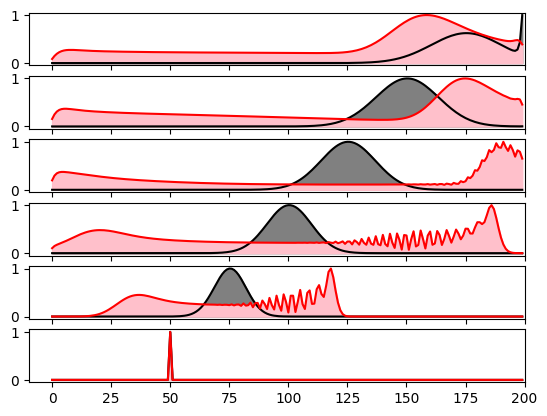

In [49]:
level = [n for n in range(0, N)] # List containing the population levels ([0, 1, 2, 3, ..., 200])
n_graphs = 6
fig, axs = plt.subplots(n_graphs, sharex=True)
print(len(Population_50_incoh))
i = 5
for pop in Population_50_incoh:
    axs[i].plot(level, pop, color='black')
    plt.xlim(right=200)
    axs[i].fill_between(level, pop, color='grey')
    i -= 1

i = 5
for pop in Population_50_coh:
    axs[i].plot(level, pop, color='red')
    plt.xlim(right=200)
    axs[i].fill_between(level, pop, color='pink')
    i -= 1

This is Figure 1. (a) without the normalization.

Now, if the battery is initially empty, the initial state is $\rho_0$:

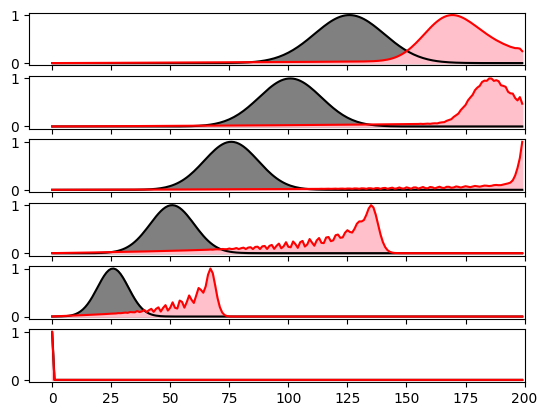

In [50]:
rho_B_0_incoh = rho_B_0 # Initial state of the qubits (Incoherent charging)
rho_B_0_coh = rho_B_0 # Initial state of the qubits (Coherent charging)
Population_0_incoh = [[expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)]] # List containing the populations of the QB after a certain amount of collisions (Incoherent charging)
Population_0_coh = [[expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)]] # List containing the populations of the QB after a certain amount of collisions (Coherent charging)

for col in range(0, n_collisions+1): # Collision dynamics
    # Incoherent charging
    rho1 = tensor(rho_B_0_incoh, rho_Q_incoh)
    rhof_inc = Ut * rho1 * Ut.dag()
    rho_B_0_incoh = rhof_inc.ptrace(0) # Battery state after collision (incoherent)

    # Coherent charging
    rho2 = tensor(rho_B_0_coh, rho_Q_coh)
    rhof_coh = Ut * rho2 * Ut.dag()
    rho_B_0_coh = rhof_coh.ptrace(0) # Battery state after collision (coherent)

    if(col == 100):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)] # Populations after 100 collisions (incoherent)
        Pmax = max(Pn_incoh) # Finding the maximum value
        Pn_incoh = [pop/Pmax for pop in Pn_incoh] # Normalization
        Population_0_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)] # Populations after 100 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_0_coh.append(Pn_coh)

    if(col == 200):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)] # Populations after 200 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_0_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)] # Populations after 200 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_0_coh.append(Pn_coh)

    if(col == 300):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)] # Populations after 300 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_0_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)] # Populations after 300 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_0_coh.append(Pn_coh)

    if(col == 400):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)] # Populations after 400 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_0_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)] # Populations after 400 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_0_coh.append(Pn_coh)

    if(col == 500):
        # Incoherent charging
        Pn_incoh = [expect(rho_B_0_incoh, basis(N, k)) for k in range(0, N)] # Populations after 500 collisions (incoherent)
        Pmax = max(Pn_incoh)
        Pn_incoh = [pop/Pmax for pop in Pn_incoh]
        Population_0_incoh.append(Pn_incoh)
        # Coherent charging
        Pn_coh = [expect(rho_B_0_coh, basis(N, k)) for k in range(0, N)] # Populations after 500 collisions (coherent)
        Pmax = max(Pn_coh)
        Pn_coh = [pop/Pmax for pop in Pn_coh]
        Population_0_coh.append(Pn_coh)

fig, axs = plt.subplots(n_graphs, sharex=True)

i = 5
for pop in Population_0_incoh:
    axs[i].plot(level, pop, color='black')
    plt.xlim(right=200)
    axs[i].fill_between(level, pop, color='grey')
    i -= 1

i = 5
for pop in Population_0_coh:
    axs[i].plot(level, pop, color='red')
    plt.xlim(right=200)
    axs[i].fill_between(level, pop, color='pink')
    i -= 1

This is Figure 1. (b) without the normalization.

Now, let's calculate the total energy of the battery as a function of the number of collisions, which can be expressed as

$$ E_n = \text{Tr}\{H_B \rho_B'\}, $$

considering the QB is initialy empty $\rho_B = \rho_0 = |0\rangle \langle 0|$.

Another important figure of merit is the ergotropy $\mathcal{E}$, which is defined as

$$ \mathcal{E} = \text{Tr}\{H_B \rho\} - \text{Tr}\{H_B \sigma_{\rho}\}, $$

where $\sigma_{\rho}$ is the passive state of $\rho$:

$$ \sigma_{\rho} = \sum_k \lambda_k |E_k\rangle \langle E_k|. $$

Here, $\lambda_k$ are the eigenvalues of $\rho$, sorted in descending order, and $|E_k\rangle$ are the eigenstates of $H_B$, sorted in increasing eigenvalue order.

c:\Users\norab\Documents\Ufal\Mestrado\qutip\venv\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\norab\Documents\Ufal\Mestrado\qutip\venv\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


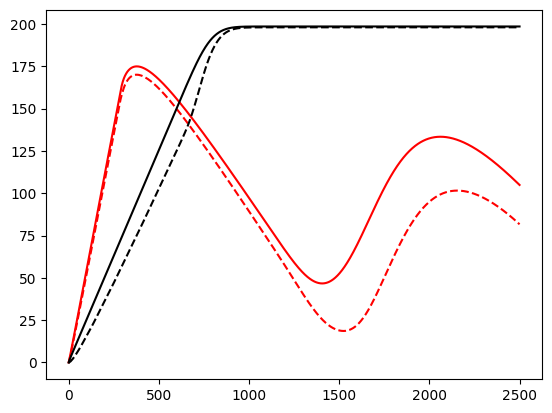

In [51]:
from ergotropy import ergotropia_no_tempo
fig, ax1 = plt.subplots()

n_collisions = 2500
E_coh = [(H_B * rho_B_0).tr()]
E_incoh = [(H_B * rho_B_0).tr()]
rho_B_incoh = rho_B_0
rho_B_coh = rho_B_0
rho_B_coh_list = [rho_B_coh]
rho_B_incoh_list = [rho_B_incoh]

for _ in range(0, int(n_collisions)):
        
        # Incoherent charging
        rho1 = tensor(rho_B_incoh, rho_Q_incoh) # 
        rhof_inc = Ut * rho1 * Ut.dag()
        rho_B_incoh = rhof_inc.ptrace(0) # Battery state after collision
        E_incoh.append((H_B * rho_B_incoh).tr())
        rho_B_incoh_list.append(rho_B_incoh)

        # Coherent charging
        rho2 = tensor(rho_B_coh, rho_Q_coh) # 
        rhof_coh = Ut * rho2 * Ut.dag()
        rho_B_coh = rhof_coh.ptrace(0) # Battery state after collision
        E_coh.append((H_B * rho_B_coh).tr())
        rho_B_coh_list.append(rho_B_coh)

erg_coh = ergotropia_no_tempo(rho_B_coh_list, H_B, N)
erg_incoh = ergotropia_no_tempo(rho_B_incoh_list, H_B, N)
ax1.plot(range(0, n_collisions+1), E_coh, color='red')
ax1.plot(range(0, n_collisions+1), erg_coh, color='red', linestyle='--')
ax1.plot(range(0, n_collisions+1), E_incoh, color='black')
ax1.plot(range(0, n_collisions+1), erg_incoh, color='black', linestyle='--')


Finally, this is Figure 3 (a) or, at least, part of it.